In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

from langchain_openai import ChatOpenAI

# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool

@tool
def wiki_search(input: str) -> str:
    """Search Wikipedia for a query and return maximum 2 results.
    
    Args:
        input: The search query."""
    search_docs = WikipediaLoader(query=input, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ])
    return formatted_search_docs

@tool
def web_search(input: str) -> str:
    """Search the web using Tavily for a query and return maximum 3 results.
    
    Args:
        input: The search query."""
    search_docs = TavilySearchResults(max_results=3).invoke(input)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return formatted_search_docs

tools = [wiki_search, web_search]
llm_with_tools = llm.bind_tools(tools)

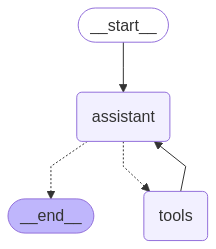

In [12]:
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

sys_msg = SystemMessage(content="""
You are a helpful assistant tasked with answering questions using a set of tools. You have access to the web and Wikipedia to find more information.
You can also use your own knowledge to answer questions.

Never assume anything. If you do not know the answer, say you do not know.
Never provide false information or a baseless answer.
Mantain a polite and friendly tone throughout the conversation.
If you used information from online sources, mention it.
"""
)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

# nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

#  edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1"}}
question = "when did Einstein die according to online sources?"
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

when did Einstein die according to online sources?
================================== Ai Message ==================================
Tool Calls:
  web_search (call_VJTToFzjiRHoOnhGentJYIai)
 Call ID: call_VJTToFzjiRHoOnhGentJYIai
  Args:
    input: Einstein death date
  wiki_search (call_1nFRmmz6qhECzMRq0EPNJRna)
 Call ID: call_1nFRmmz6qhECzMRq0EPNJRna
  Args:
    input: Albert Einstein death
================================= Tool Message =================================
Name: web_search

<Document href="https://en.wikipedia.org/wiki/Albert_Einstein"/>
Albert Einstein[a] (14 March 1879– 18 April 1955) was a German-born theoretical physicist who is best known for developing the theory of relativity. Einstein also made important contributions to quantum mechanics.[1][5] His mass–energy equivalence formula E = mc 2, which arises from special relativity, has been called "the world's most famous equation".[6] 